<a href="https://colab.research.google.com/github/edwin-19/nemo_example/blob/master/Nemo_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update && apt-get install -y libsndfile1 ffmpeg
!pip install Cython
!pip install datasets
!pip install jiwer

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,087 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,230 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [25.6 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [969 kB]
Hit:13 https://ppa.launchpadcontent.

In [2]:
## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

DEPRECATION: git+https://github.com/NVIDIA/NeMo.git@main#egg=nemo_toolkit[all] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/NVIDIA/NeMo.git (to revision main) to /tmp/pip-install-izmc780z/nemo-toolkit_208a99e802364e81947083d0e800e8a4
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA/NeMo.git /tmp/pip-install-izmc780z/nemo-toolkit_208a99e802364e81947083d0e800e8a4
  Resolved https://github.com/NVIDIA/NeMo.git to commit 2fa7abfb7311f1a4115dfa47afb80339697ec88d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 9

In [3]:
!wget https://dldata-public.s3.us-east-2.amazonaws.com/an4_sphere.tar.gz
!tar -xzvf an4_sphere.tar.gz

--2023-07-31 11:44:52--  https://dldata-public.s3.us-east-2.amazonaws.com/an4_sphere.tar.gz
Resolving dldata-public.s3.us-east-2.amazonaws.com (dldata-public.s3.us-east-2.amazonaws.com)... 3.5.133.140, 52.219.96.144, 3.5.133.14, ...
Connecting to dldata-public.s3.us-east-2.amazonaws.com (dldata-public.s3.us-east-2.amazonaws.com)|3.5.133.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64327561 (61M) [application/x-gzip]
Saving to: ‘an4_sphere.tar.gz’

an4_sphere.tar.gz   100%[===================>]  61.35M  34.4MB/s    in 1.8s    

2023-07-31 11:44:54 (34.4 MB/s) - ‘an4_sphere.tar.gz’ saved [64327561/64327561]

an4/
an4/README
an4/etc/
an4/etc/an4_test.fileids
an4/etc/an4.ug.lm
an4/etc/an4.ug.lm.DMP
an4/etc/an4_train.fileids
an4/etc/an4_train.transcription
an4/etc/an4_test.transcription
an4/etc/an4.dic
an4/etc/an4.phone
an4/etc/an4.filler
an4/wav/
an4/wav/an4_clstk/
an4/wav/an4_clstk/fash/
an4/wav/an4_clstk/fash/an251-fash-b.sph
an4/wav/an4_clstk/fash/an253-

# Lets Start with ASR (Speech to Text)
- We import our modules
- Convert our sph to wav files
- Use quartznet provided by nemo to run our asr module

In [4]:
import nemo.collections.asr as nemo_asr
import jiwer
from pathlib import Path
from pydub import AudioSegment
from tqdm import tqdm
from IPython.display import Audio
import random

In [5]:
# Lets convert the files into wavs
audio_list = random.sample(list(Path('an4/').rglob('**/*.sph')), 800)
for aud_path in tqdm(audio_list):
  audio = AudioSegment.from_file(aud_path)
  audio.export(str(aud_path).replace('.sph', '.wav'), format='wav')

100%|██████████| 800/800 [01:59<00:00,  6.68it/s]


In [39]:
wavs_list = list(Path('an4/').rglob('**/*.wav'))
wavs_list = np.random.choice(wavs_list, 10)
wavs_list = [str(wav) for wav in wavs_list]

In [46]:
nemo_asr.models.EncDecCTCModel.list_available_models()

[PretrainedModelInfo(
 	pretrained_model_name=QuartzNet15x5Base-En,
 	description=QuartzNet15x5 model trained on six datasets: LibriSpeech, Mozilla Common Voice (validated clips from en_1488h_2019-12-10), WSJ, Fisher, Switchboard, and NSC Singapore English. It was trained with Apex/Amp optimization level O1 for 600 epochs. The model achieves a WER of 3.79% on LibriSpeech dev-clean, and a WER of 10.05% on dev-other. Please visit https://ngc.nvidia.com/catalog/models/nvidia:nemospeechmodels for further details.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo
 ),
 PretrainedModelInfo(
 	pretrained_model_name=stt_en_quartznet15x5,
 	description=For details about this model, please visit https://ngc.nvidia.com/catalog/models/nvidia:nemo:stt_en_quartznet15x5,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_quartznet15x5/versions/1.0.0rc1/files/stt_en_quartznet15x5.nemo
 ),
 PretrainedModelInfo(
 	pre

In [47]:
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="stt_en_jasper10x5dr")

[NeMo I 2023-07-31 12:28:24 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_jasper10x5dr/versions/1.0.0rc1/files/stt_en_jasper10x5dr.nemo to /root/.cache/torch/NeMo/NeMo_1.20.0rc0/stt_en_jasper10x5dr/856ae08d5c4bd78b5e27f696e96f7aab/stt_en_jasper10x5dr.nemo
[NeMo I 2023-07-31 12:29:04 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-07-31 12:29:22 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/voices/train_1k.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - ''''
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    
[NeMo W 2023-07-31 12:29:22 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /data2/vo

[NeMo I 2023-07-31 12:29:22 features:289] PADDING: 16
[NeMo I 2023-07-31 12:29:39 save_restore_connector:249] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.20.0rc0/stt_en_jasper10x5dr/856ae08d5c4bd78b5e27f696e96f7aab/stt_en_jasper10x5dr.nemo.


In [48]:
transribe_text = quartznet.transcribe(wavs_list[:10])

Transcribing:   0%|          | 0/3 [00:00<?, ?it/s]

In [49]:
transribe_text

['repeat',
 'x y i v y one',
 'eight two six eight six eight seven',
 'rub out f b m j seven ten',
 'l u d w i c k',
 'p itts b u r g h',
 'rubet p o o b eght',
 'rub out e z u a i fifteen',
 's p r i n g h o u s e la ne',
 'hr i c ha r d']

In [50]:
from IPython.display import Audio, display
from ipywidgets import widgets
import soundfile as sf

audio_widgets = []
text_widgtes = []
for wav, transcribe in zip(wavs_list[:5], transribe_text[:5]):
    y, sr = sf.read(wav)
    out = widgets.Output()
    with out:
        display(Audio(data=y, rate=sr))
    text = widgets.Label('Transcribe: {}'.format(transcribe))
    audio_widgets.append(out)
    audio_widgets.append(text)

layout = widgets.Layout(grid_template_columns='1fr 1fr')
widgets.GridBox(audio_widgets, layout=layout)

GridBox(children=(Output(), Label(value='Transcribe: repeat'), Output(), Label(value='Transcribe: x y i v y on…

# Lets try tts models next
- For TTS we need a mel spec generator
- Vocoder (to convert our mel spec to a wav)
- The process it as follows:
  - Convert text to ids -> convert ids to mel spec -> convert msl spec to a wav format


In [10]:
from nemo.collections.tts.models import Tacotron2Model, FastPitchModel
from nemo.collections.tts.models import HifiGanModel
import torch
import numpy as np
import soundfile as sf
from matplotlib import pyplot as plt
import librosa
import librosa.display

In [65]:
# Show all models
HifiGanModel.list_available_models()
# FastPitchModel.list_available_models()
# Tacotron2Model.list_available_models()

[PretrainedModelInfo(
 	pretrained_model_name=tts_en_hifigan,
 	description=This model is trained on LJSpeech audio sampled at 22050Hz and mel spectrograms generated from Tacotron2, TalkNet, and FastPitch. This model has been tested on generating female English voices with an American accent.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo,
 	class_=<class 'nemo.collections.tts.models.hifigan.HifiGanModel'>
 ),
 PretrainedModelInfo(
 	pretrained_model_name=tts_en_lj_hifigan_ft_mixertts,
 	description=This model is trained on LJSpeech audio sampled at 22050Hz and mel spectrograms generated from Mixer-TTS. This model has been tested on generating female English voices with an American accent.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_lj_hifigan/versions/1.6.0/files/tts_en_lj_hifigan_ft_mixertts.nemo,
 	class_=<class 'nemo.collections.tts.models.hifigan.HifiGanModel'>
 ),
 PretrainedModelInfo(
 	pr

In [70]:
# Load models
vocoder = HifiGanModel.from_pretrained(model_name="tts_en_hifigan")
spec_generator = FastPitchModel.from_pretrained("tts_en_fastpitch_ipa")

vocoder.eval();
spec_generator.eval();

[NeMo I 2023-07-31 12:42:15 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.20.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2023-07-31 12:42:15 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.20.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2023-07-31 12:42:15 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-07-31 12:42:22 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2023-07-31 12:42:22 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2023-07-31 12:42:22 features:289] PADDING: 0


[NeMo W 2023-07-31 12:42:22 features:266] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2023-07-31 12:42:22 features:289] PADDING: 0
[NeMo I 2023-07-31 12:42:24 save_restore_connector:249] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.20.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2023-07-31 12:42:24 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.20.0rc0/tts_en_fastpitch_align_ipa/63969a9d8c2d5f4870d16fbf8064a5e0/tts_en_fastpitch_align_ipa.nemo.
[NeMo I 2023-07-31 12:42:24 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.20.0rc0/tts_en_fastpitch_align_ipa/63969a9d8c2d5f4870d16fbf8064a5e0/tts_en_fastpitch_align_ipa.nemo
[NeMo I 2023-07-31 12:42:24 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-07-31 12:43:14 experimental:26] `<class 'nemo.collections.tts.g2p.models.i18n_ipa.IpaG2p'>` is experimental and not ready for production yet. Use at your own risk.
[NeMo W 2023-07-31 12:43:17 i18n_ipa:124] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2023-07-31 12:43:17 experimental:26] `<class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'>` is experimental and not ready for production yet. Use at your own risk.
[NeMo W 2023-07-31 12:43:17 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
 

[NeMo I 2023-07-31 12:43:17 features:289] PADDING: 1
[NeMo I 2023-07-31 12:43:17 save_restore_connector:249] Model FastPitchModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.20.0rc0/tts_en_fastpitch_align_ipa/63969a9d8c2d5f4870d16fbf8064a5e0/tts_en_fastpitch_align_ipa.nemo.


In [76]:
# Generate wav
sent = "Hello can you tell me your name, my name is helen by the way, i like to read books"
sent = "I am sorry to hear about the inconvenience. Please tell me more about what happened so I can assist you better."
# sent = "aishiteru"
with torch.no_grad():
  parsed = spec_generator.parse(sent)
  spectrogram = spec_generator.generate_spectrogram(tokens=parsed)
  audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)

if isinstance(audio, torch.Tensor):
  audio = audio.to('cpu').numpy()

In [77]:
# lets save the wav for later use
sf.write('test.wav', audio[0], 22050, "PCM_16")

# Display wav
Audio(audio, rate=22050, autoplay=True)

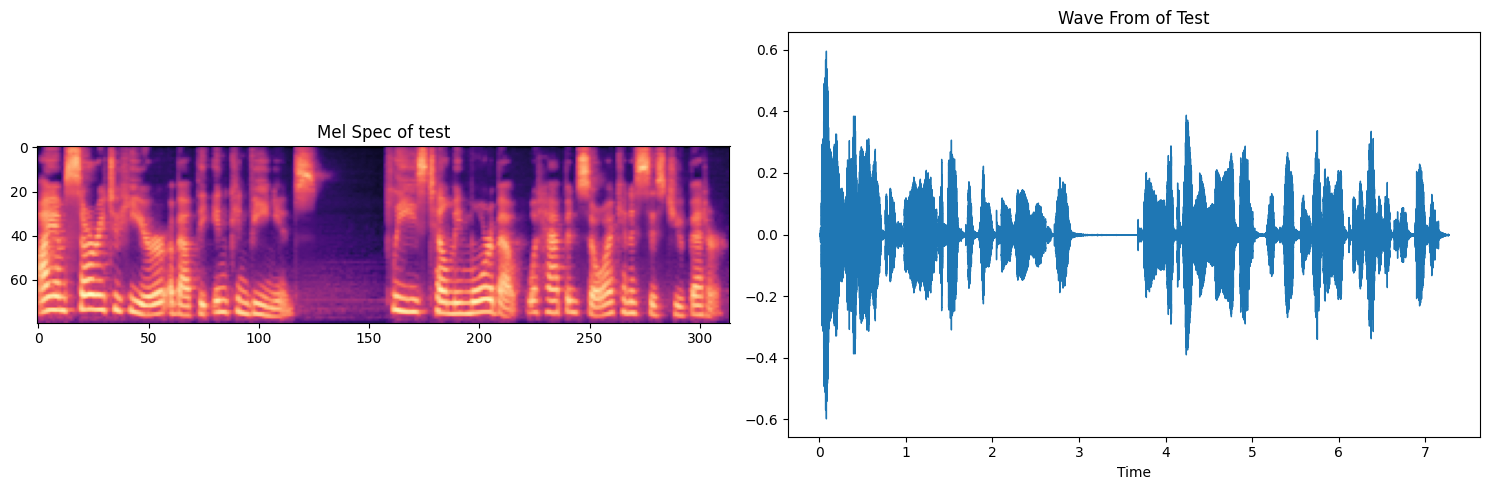

In [61]:
# Display our mel spec from our generated audio
y, sr = librosa.load('test.wav')
spec = librosa.feature.melspectrogram(
    y=y, sr=sr,
    n_fft=2048,
    hop_length=512,
    win_length=None,
    window='hann',
    center=True,
    pad_mode='reflect',
    power=2.0,
    n_mels=80
)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Mel Spec of test')
plt.imshow(np.log(spec)[::-1], cmap='magma')
plt.subplot(1, 2, 2)
plt.title('Wave From of Test')
librosa.display.waveshow(y, sr=sr)

plt.tight_layout()
plt.show()

# Text Classification
- Lets do text classification next
- We can use bert to classifiy some text

In [78]:
from nemo.collections.nlp.models.text_classification import TextClassificationModel
import wget
import os
from omegaconf import OmegaConf

In [79]:
def get_config():
  MODEL_CONFIG = "text_classification_config.yaml"
  CONFIG_DIR =  './configs/'
  os.makedirs(CONFIG_DIR, exist_ok=True)
  if not os.path.exists(CONFIG_DIR + MODEL_CONFIG):
      print('Downloading config file...')
      wget.download(f'https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/nlp/text_classification/conf/' + MODEL_CONFIG, CONFIG_DIR)
      print('Config file downloaded!')
  else:
      print ('config file already exists')

  return f'./configs/{MODEL_CONFIG}'

In [18]:
config_path = get_config()
config = OmegaConf.load(config_path)
config.model.language_model.pretrained_model_name = "bert-base-uncased"
config.model.dataset.num_classes=2

model = TextClassificationModel(cfg=config.model)

Config file downloaded!
[NeMo I 2023-07-31 11:48:42 tokenizer_utils:130] Getting HuggingFace AutoTokenizer with pretrained_model_name: bert-base-uncased, vocab_file: None, merges_files: None, special_tokens_dict: {}, and use_fast: False


Using eos_token, but it is not set yet.
Using bos_token, but it is not set yet.
[NeMo W 2023-07-31 11:48:44 modelPT:244] You tried to register an artifact under config key=tokenizer.vocab_file but an artifact for it has already been registered.


[NeMo I 2023-07-31 11:48:44 text_classification_model:167] Dataloader config or file_path for the train is missing, so no data loader for test is created!
[NeMo I 2023-07-31 11:48:44 text_classification_model:184] Dataloader config or file_path for the validation is missing, so no data loader for test is created!
[NeMo I 2023-07-31 11:48:44 text_classification_model:193] Dataloader config or file_path for the test is missing, so no data loader for test is created!


[NeMo W 2023-07-31 11:48:44 nlp_overrides:253] Apex was not found. Please see the NeMo README for installation instructions: https://github.com/NVIDIA/apex
    Megatron-based models require Apex to function correctly.


In [81]:
queries = ['by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .',
      'director rob marshall went out gunning to make a great one .',
      'uneasy mishmash of styles and genres .', "i hate you"]

labels = ['negative', 'positive']
# max_seq_length=512 is the maximum length BERT supports.
with torch.no_grad():
  results = model.classifytext(queries=queries, batch_size=3, max_seq_length=512)
for res, qu in zip(results, queries):
  print('Query: {}, Label: {}'.format(qu, labels[res]))

[NeMo W 2023-07-31 12:46:00 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/collections/nlp/data/text_classification/text_classification_dataset.py:203: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
      torch.LongTensor(padded_input_ids),
    
[NeMo W 2023-07-31 12:46:00 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/collections/nlp/data/text_classification/text_classification_dataset.py:203: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
      torch.LongTensor(padded_input_ids),
    


Query: by the end of no such thing the audience , like beatrice , has a watchful affection for the monster ., Label: negative
Query: director rob marshall went out gunning to make a great one ., Label: positive
Query: uneasy mishmash of styles and genres ., Label: negative
Query: i hate you, Label: positive


# Token Classification
- Lets but not least last test out named entity recoginition
- We can use bert for the same purpose

In [20]:
from nemo.collections import nlp as nemo_nlp

In [21]:
pretrained_ner_model = nemo_nlp.models.TokenClassificationModel.from_pretrained(model_name="ner_en_bert")

[NeMo I 2023-07-31 11:48:54 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/ner_en_bert/versions/1.10/files/ner_en_bert.nemo to /root/.cache/torch/NeMo/NeMo_1.20.0rc0/ner_en_bert/8186f86c83b11d70b43b9ead695e7eda/ner_en_bert.nemo
[NeMo I 2023-07-31 11:49:10 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2023-07-31 11:49:14 tokenizer_utils:130] Getting HuggingFace AutoTokenizer with pretrained_model_name: bert-base-uncased, vocab_file: /tmp/tmpwv7v9lua/tokenizer.vocab_file, merges_files: None, special_tokens_dict: {}, and use_fast: False


Using eos_token, but it is not set yet.
Using bos_token, but it is not set yet.
[NeMo W 2023-07-31 11:49:14 modelPT:244] You tried to register an artifact under config key=tokenizer.vocab_file but an artifact for it has already been registered.
[NeMo W 2023-07-31 11:49:14 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    text_file: text_train.txt
    labels_file: labels_train.txt
    shuffle: true
    num_samples: -1
    batch_size: 64
    
[NeMo W 2023-07-31 11:49:14 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    text_file: text_dev.txt
    labels_file: labels_dev.txt
    shuffle: false
    num_samples: -1
    batch_size: 64
    

[NeMo I 2023-07-31 11:49:17 save_restore_connector:249] Model TokenClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.20.0rc0/ner_en_bert/8186f86c83b11d70b43b9ead695e7eda/ner_en_bert.nemo.


In [82]:
# define the list of queries for inference
queries = [
    'we bought four shirts from the nvidia gear store in santa clara.',
    'Nvidia is a company.',
    'The Adventures of Tom Sawyer by Mark Twain is an 1876 novel about a young boy growing '
    + 'up along the Mississippi River.',
]
results = pretrained_ner_model.add_predictions(queries)

for index, (query, result) in enumerate(zip(queries, results)):
  if index == 0:
    print(f'\n=======Results=======\nQuery : {query}')
  else:
    print(f'Query : {query}')

  if index == len(queries) - 1:
    print(f'Result: {result.strip()}')
  else:
    print(f'Result: {result.strip()}\n')

[NeMo I 2023-07-31 12:47:15 token_classification_dataset:123] Setting Max Seq length to: 25
[NeMo I 2023-07-31 12:47:15 data_preprocessing:404] Some stats of the lengths of the sequences:
[NeMo I 2023-07-31 12:47:15 data_preprocessing:406] Min: 9 |                  Max: 25 |                  Mean: 17.0 |                  Median: 17.0
[NeMo I 2023-07-31 12:47:15 data_preprocessing:412] 75 percentile: 21.00
[NeMo I 2023-07-31 12:47:15 data_preprocessing:413] 99 percentile: 24.84


[NeMo W 2023-07-31 12:47:15 token_classification_dataset:152] 0 are longer than 25


[NeMo I 2023-07-31 12:47:15 token_classification_dataset:155] *** Example ***
[NeMo I 2023-07-31 12:47:15 token_classification_dataset:156] i: 0
[NeMo I 2023-07-31 12:47:15 token_classification_dataset:157] subtokens: [CLS] we bought four shirts from the n ##vid ##ia gear store in santa clara . [SEP]
[NeMo I 2023-07-31 12:47:15 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
[NeMo I 2023-07-31 12:47:15 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
[NeMo I 2023-07-31 12:47:15 token_classification_dataset:160] subtokens_mask: 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0

=======Results=======
Query : we bought four shirts from the nvidia gear store in santa clara.
Result: we bought four shirts from the nvidia[B-ORG] gear store in santa[B-LOC] clara[I-LOC].

Query : Nvidia is a company.
Result: Nvidia[B-ORG] is a company.

Query : The Adventures of Tom Sawyer by Mark Twain is an 1876 nove

# Export model to onnx
- Finally lets export all of our models to onnx
- Onnx is model format thats more suitble for inference

In [23]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.1 MB/s eta 0:00:00


In [24]:
import os
import onnxruntime as ort

In [25]:
outdir = "onnx/"
if not os.path.exists(outdir):
  os.makedirs(outdir)
quart_name = 'quartnet.onnx'
bert_name = 'bert_ner.onnx'

In [83]:
print('Exporting ONNX model')
quartz_export_path = os.path.join(outdir, quart_name)
quartznet.export(quartz_export_path)

bert_export_path = os.path.join(outdir, bert_name)
pretrained_ner_model.export(bert_export_path)

[NeMo W 2023-07-31 12:50:38 conv_asr:73] Turned off 108 masked convolutions


Exporting ONNX model


[NeMo W 2023-07-31 12:51:23 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2033: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input audio_signal
      warnings.warn(
    
[NeMo W 2023-07-31 12:51:23 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2033: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input length
      warnings.warn(
    
[NeMo W 2023-07-31 12:51:23 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2033: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input logprobs
      warnings.warn(
    
[NeMo W 2023-07-31 12:51:24 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/coll

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[NeMo I 2023-07-31 12:52:34 exportable:130] Successfully exported EncDecCTCModel to onnx/quartnet.onnx


[NeMo W 2023-07-31 12:52:36 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2033: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input input_ids
      warnings.warn(
    
[NeMo W 2023-07-31 12:52:36 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2033: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input attention_mask
      warnings.warn(
    
[NeMo W 2023-07-31 12:52:36 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2033: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input token_type_ids
      warnings.warn(
    
[NeMo W 2023-07-31 12:52:36 nemo_logging:349] /usr/local/lib/python3.10/dist-package

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[NeMo I 2023-07-31 12:52:47 exportable:130] Successfully exported TokenClassificationModel to onnx/bert_ner.onnx


(['onnx/bert_ner.onnx'],
 ['nemo.collections.nlp.models.token_classification.token_classification_model.TokenClassificationModel exported to ExportFormat.ONNX'])

In [84]:
quartz_sess = ort.InferenceSession(quartz_export_path)

In [85]:
bert_sess = ort.InferenceSession(bert_export_path)

In [105]:
labels = list(pretrained_ner_model.cfg.label_ids.keys())
labels

['O',
 'B-GPE',
 'B-LOC',
 'B-MISC',
 'B-ORG',
 'B-PER',
 'B-TIME',
 'I-GPE',
 'I-LOC',
 'I-MISC',
 'I-ORG',
 'I-PER',
 'I-TIME']

In [104]:
# Infer with onnxruntime bert
sent = "we bought four shirts from the nvidia gear store in santa clara."
# sent = "Hello my name is Edwin"
inputs = pretrained_ner_model.tokenizer.tokenizer(sent, return_tensors='np')
inputs = {key:np.array(val) for key, val in inputs.items()}
output = bert_sess.run(None, inputs)[0]
for ids, pred in zip(inputs['input_ids'][0], output[0].argmax(axis=1)):
  print(labels[pred], '|', ''.join(pretrained_ner_model.tokenizer.tokenizer.decode(ids)))
  # print()

O | [ C L S ]
O | w e
O | b o u g h t
O | f o u r
O | s h i r t s
O | f r o m
O | t h e
B-ORG | n
I-ORG | # # v i d
I-LOC | # # i a
O | g e a r
O | s t o r e
O | i n
B-LOC | s a n t a
I-LOC | c l a r a
O | .
O | [ S E P ]


pull nvidia triton server from docker
docker pull nvcr.io/nvidia/tritonserver:23.07-py3